# Aufgabenstellung

Es soll ein Model erstellt werden, welches einem Benutzer bei Eingabe einer Frage ähnliche, bereits vorhanden Fragen vorstellt.
Je präsizer der Bentuzer die Frage formuliert, umso präziser sollen auch die Vorhersagen sein.

# Lösung
## Betrachtung des Datensatzes
Der Datensatz beinhaltet neben den README-Dateien 3 CSV-Dateien

### Trainings-Datensatz
Der Trainingsdatensatz ist in der Datei 'training.csv' enthalten.
Der Datensatz enthält insgesamt 5 Attribute pro Datum.
Eine allgemeine 'id', eine 'qid1' & 'qid2' für die jeweilige Frage.
Schlussendlich folgen die beiden Fragen sowie die Spalte 'is_duplicate', bei welcher zwei Fragen mit gleicher Intention mit dem Label 1 markiert sind.

#### Aussortieren nicht benötigter Parameter

Die Attribute 'question1', 'question2' und 'is_duplicate' werden auf jedenfall benötigt, da in dieser die Fragen sowie das Klassiefizierungslabel enthalten sind

Im zu trainierenden Modell soll rein der textliche Inhalt der Fragen von Bedeutung sein. Aus diesem Grund werden beim Einlesen der Daten die Attribute 'id', 'qid1' & 'qid2' nicht mit geladen.

#### Vorverarbeitung der Daten
Im geladenen Dataframe werden die Datensätze entfernet, welche in einer der Attribute ein NaN-Value besitzen. Dies ist nötig, da aus diesen Datensätzen keinen sinnvollen Rückschlüsse gezogen werden können.

Außerdem werden Duplikate entfernt, da ein Training des selben Datensatzen nicht zur Verbesserung des Modelles beiträgt.


In [3]:
# https://www.kaggle.com/nkaps98/quora-question-pairs-glove-lstm
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Multiply, Flatten, Dropout, Dense, LSTM
from sklearn.model_selection import train_test_split
tf.random.set_seed(35)

df_train = pd.read_csv(
    "./fragen/train.csv",
    usecols = ['question1', 'question2', 'is_duplicate'],
    encoding = 'utf-8'
)

df_train.dropna(inplace=True)
df_train.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Damit der Text präziser verarbeitet werden kann, werden außerdem alle Buchstaben in lowercase umgewandelt

In [4]:
df_train = df_train.applymap(lambda s: s.lower() if type(s) == str else s)

### Visualisieren der Trainingsdaten
#### Verteilung der Labels in den Trainingsdaten

Im folgenden wird die Verteilung der Label in den Trainingsdaten mit Hilfe eines Balkendiagrammes visualisiert.

Text(0.5, 1.0, 'Number of elements found in dataset')

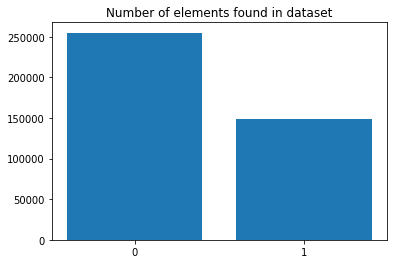

In [5]:
fig, ax = plt.subplots()
label_dist = df_train.is_duplicate.value_counts()

ax.bar([0,1],label_dist)
ax.set_xticks([0,1], labels=[0,1])
ax.set_title('Number of elements found in dataset')

#### Anzahl der Duplikate

In [6]:
print(df_train.duplicated(keep='first').sum())
df_train.groupby(df_train.columns.tolist(),as_index=False).size()

341


,question1,question2,is_duplicate,size
0,can i pay with a debit card on paypal?,can you transfer paypal funds onto a debit car...,0,1
1,does new york state have a flagship university?,how can the new york state be fixed?,0,1
2,failures haunt me all the time.how do i cope up?,what can help me cope up with my failure?,1,1
3,how do i make the time lapse images using an ...,how do i make time-lapse photography?,0,1
4,i didn't file a police report for a car accid...,why don't i get the money i paid for a year wo...,0,1
...,...,...,...,...
403941,你说我说中文会不会有人看得懂. what does this sentence mean?,what does this sentence mean?,0,1
403942,格局how to translate?,how do you translate this?,0,1
403943,格局how to translate?,"how would you translate ""一百回""?",0,1
403944,"黎权锋, help me make up an english name, thank yo...",would you want to help me come up with a name ...,0,1


In [7]:
label_dist[0] - label_dist[1]

105761

Es lässt sich beobachten, das circa 106k mehr Fragen mit dem Label 0, also sinnlich nicht verwandt, versehen sind. Dies kann bei dem trainierten Modell dazu führen, dass das Model zuverlässiger bei der Erkennung von nicht gleichen Fragen als bei gleichen Fragen ist.

## Einlesen der Testdaten

In [8]:
test_data_raw = pd.read_csv(
    "./fragen/test.csv",
    usecols= ['test_id', 'question1', 'question2'],
    encoding='utf-8'
)

test_data_raw = test_data_raw.applymap(lambda s: s.lower() if type(s) == str else s)
test_data_raw.dropna(inplace=True)
test_data_raw.head()

submission_data_raw = pd.read_csv(
    "./fragen/sample_submission.csv",
    usecols = ['test_id', 'is_duplicate']
)

submission_data_raw.dropna(inplace=True)
submission_data_raw.head()

/tmp/ipykernel_12505/1888995335.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data_raw = pd.read_csv(


,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


### Zusammenführen der beiden Dataframes

In [9]:
test_data_merged_raw = test_data_raw.merge(submission_data_raw, left_on="test_id", right_on="test_id")

test_data_merged_raw.dropna(inplace=True)
test_data_merged_raw.drop_duplicates(inplace=True)
test_data_merged_raw.head()

test_data_merged_raw.is_duplicate.value_counts()

1    2345790
Name: is_duplicate, dtype: int64

### Kodieren der Fragen

In [10]:
target_test = test_data_merged_raw.pop('is_duplicate')

## Aufteilung der Trainingsdaten in Trainings- und Validierungsdaten
Vom Trainingsdatensatz wird die Label-Spalte 'is_duplicate' abgespaltet

Der Trainingsdatensatz wird in Trainings- und Validierungsdaten aufgeteilt.

20% des Trainingsdatensatzes werden als Validierungsdatensatz abgespalten.

Für ein reproduzierbares Ergebnis wurden bei der Aufteilung des Datensatzes ein festgelegter Seed verwendet.

In [11]:
target = df_train.pop('is_duplicate')

xTrain, xValid, yTrain, yValid = train_test_split(df_train, target, test_size=0.2, random_state=35)
xTrain.head()

,question1,question2
283108,which are the best german universities for an ...,which are the best german universities for an ...
73636,i like being merchant navy?,are astronauts allowed to masturbate in space?
46418,what is the legal definition of a human being?...,what do men think about menstrual cycle?
11449,how can i handle having personal issues with m...,how do i take things my partner says less pers...
283432,"how cold can the gobi desert get, and how do i...","how cold can the gobi desert get, and how do i..."


## Erstellung eines Tokenizers

Um ein besseres Training zu ermöglichen, wird ein Tokenizer erstellt, welche die Wörter der Fragen einem Integer-Value zuordnet.
Der Tokenizer wird auf alle Fragen des nicht gesplitteten Trainingsdatensatzes angewandt.

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(df_train.question1.values) + list(df_train.question2.values))

## Kodierung  und Anpassung der Form der Fragen
Die Fragen der gesplitteten Datensätzen werden mittels des erstellten Tokenizer kodiert, sprich der String zu einem Array aus Integer werden umgewandelt.

Damit die Fragen auch alle das gleiche Format besitzen, wird das Array anschließend auf eine Länge von 40 gestreckt.

Positionen, welche nicht durch die Interger-Werte der Wörter des vorherigen Stringes gefüllt wurden, werden mit dem Wert 0 gefüllt.

In [13]:
def tokenizeQuestions(df_questions):
    tokenized_questions = tokenizer.texts_to_sequences(df_questions)
    return pad_sequences(tokenized_questions, maxlen = 36, padding = 'post')

In [14]:
q1_train = tokenizeQuestions(xTrain.question1)
q2_train = tokenizeQuestions(xTrain.question2)

q1_valid = tokenizeQuestions(xValid.question1)
q2_valid = tokenizeQuestions(xValid.question2)

q1_test = tokenizeQuestions(test_data_merged_raw.question1)
q2_test = tokenizeQuestions(test_data_merged_raw.question2)

In [15]:
word_index = tokenizer.word_index

#### Erstellung eines Dictionaries, welche später für das Finden von ähnlichen Fragen verwendet wird

In [18]:
completeQuestionsDict = np.unique(np.concatenate((q1_train, q2_train, q1_valid, q2_valid)), axis=0)
print(completeQuestionsDict)

[[    0     0     0 ...     0     0     0]
 [    1    18    10 ...     0     0     0]
 [    1    18    10 ...     0     0     0]
 ...
 [95102     9     5 ...     0     0     0]
 [95184    99     7 ...     0     0     0]
 [95457 11220  5907 ...     0     0     0]]


## Erstellung des Modelles
Das Model beinhaltet 2 Untermodelle. Die Outputs dieser Modellen werden im Lauf des Modelles zusammengefügt und weiter verarbeitet.

Die 2 Untermodelle werden benötigt, da die 2 verschiedenen Fragen 2 Modell-Inputs darstellen und jeweils entsprechend (vor)verarbeitet werden müssen.

#### Erstellung einem vorgefertigeten GloVe Model für das Embedding-Layer
Bei der Aufgabenstellung bietet es sich an, für die Gewichtung des Embedding-Layers ein vorgefertigtes Modell zu nehmen.
In dieser Ausführung wird dazu das GloVe-Modell der Standard-Univerity verwendet.
Es enthält 42B-Tokens, und einen Umfang von 1.9M Wörtern
https://github.com/stanfordnlp/GloVe


### Erstellung der Input-Modelle
Da die beiden Untermodelle einen identischen Aufbau besitzen, wurde zur Erstellung dieser eine entsprechende Funktion erstellt


In [19]:
#embeddings = {}
#with open('./glove/glove.42B.300d.txt', encoding='utf-8') as f:
#    for line in f:
#        values = line.split(' ')
#        embeddings[values[0]] = np.asarray(values[1:], dtype='float32')
#    f.close()
#print(f'Length of word embedding: {len(embeddings)}')

In [20]:
#weight_matrix = np.zeros((len(word_index)+1, 300))
#for word, i in word_index.items():
#    if embeddings.get(word) is not None:
#        weight_matrix[i] = embeddings.get(word)
#print('Null word embeddings: %d' % np.sum(np.sum(weight_matrix, axis=1) == 0))

In [69]:
def createInputModel(hp):
    model = tf.keras.Sequential()
    #hp_learning_rate = hp.Choice('weights', values=[True, False])
    #if hp_learning_rate:
    #    model.add(Embedding(len(word_index)+1, output_dim = 300, input_length = 36, weights=[weight_matrix]))
    #else:
    model.add(Embedding(len(word_index)+1, output_dim = 300, input_length = 36))
    model.add(LSTM(128, return_sequences = True))
    model.add(LSTM(128))
    hp_units = hp.Int('units', min_value = 8, max_value = 32, step = 4)
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dense(1))
    return model

# Merging the input of the two models

In [70]:
def createFinalModel(hp):
    q1_model = createInputModel(hp)
    q2_model = createInputModel(hp)
    mergedInputs = Multiply()([q1_model.output, q2_model.output])
    mergedInputs = Flatten()(mergedInputs)
    hp_units = hp.Int('units', min_value=100, max_value=150, step=10)
    mergedInputs = Dense(units=hp_units, activation = 'relu')(mergedInputs)
    mergedInputs = Dropout(0.2)(mergedInputs)
    hp_units = hp.Int('units', min_value=50, max_value=100, step=10)
    mergedInputs = Dense(units=hp_units, activation = 'relu')(mergedInputs)
    mergedInputs = Dropout(0.2)(mergedInputs)
    mergedInputs = Dense(1, activation = 'sigmoid')(mergedInputs)
    model = tf.keras.Model(inputs = [q1_model.input, q2_model.input], outputs = mergedInputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
    return model

# Create the model

In [71]:
tuner = kt.Hyperband(createFinalModel,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='optimizer',
                     project_name='g_optimizer')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

INFO:tensorflow:Reloading Oracle from existing project optimizer/g_optimizer/oracle.json
INFO:tensorflow:Reloading Tuner from optimizer/g_optimizer/tuner0.json


# Compile and fit the model

In [72]:
history = tuner.search([q1_train, q2_train], yTrain,
                    validation_data = ((q1_valid, q2_valid), yValid),
                    epochs = 20,
                    batch_size = 2048,
                    callbacks=[stop_early]
)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)

INFO:tensorflow:Oracle triggered exit


# Kreation des besten Modelles und Training

In [73]:
model = tuner.hypermodel.build(best_hps)
history = model.fit([q1_train, q2_train], yTrain,
                    validation_data = ((q1_valid, q2_valid), yValid),
                    epochs = 5,
                    batch_size = 2048
)

#val_acc_per_epoch = history.history['val_accuracy']
#best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/5
158/158 [==============================] - 38s 205ms/step - loss: 0.6442 - accuracy: 0.6405 - val_loss: 0.5708 - val_accuracy: 0.7147
Epoch 2/5
158/158 [==============================] - 31s 196ms/step - loss: 0.5388 - accuracy: 0.7333 - val_loss: 0.5236 - val_accuracy: 0.7430
Epoch 3/5
158/158 [==============================] - 32s 202ms/step - loss: 0.4923 - accuracy: 0.7599 - val_loss: 0.5148 - val_accuracy: 0.7502
Epoch 4/5
158/158 [==============================] - 31s 194ms/step - loss: 0.4558 - accuracy: 0.7791 - val_loss: 0.5123 - val_accuracy: 0.7547
Epoch 5/5
158/158 [==============================] - 33s 210ms/step - loss: 0.4261 - accuracy: 0.7931 - val_loss: 0.5264 - val_accuracy: 0.7559


## Erneutes Bauen Fitting mit der optimalen Epochen-Anzahl

In [74]:
#hypermodel = tuner.hypermodel.build(best_hps)
#history = hypermodel.fit([q1_train, q2_train], yTrain,
#                    validation_data = ((q1_valid, q2_valid), yValid),
#                    epochs = best_epoch,
#                    batch_size = 2048
#)

### Validierung
In der folgenden Funktion wird die genauigkeit des Modelles bestimmt.
Die Bestimmung der Genauigkeit erfolgt auf das Trainingsdatenset, das Validierungsdatenset als auch das Testdatenset

In [75]:
def evaluteModel(model, training, valid, test):
    trainings_eval = model.evaluate([q1_train, q2_train], yTrain, batch_size=2048)
    print(f'Trainings acc: {trainings_eval[1]}')
    valid_eval = model.evaluate([q1_valid, q2_valid], yValid, batch_size=2048)
    print(f'Validation acc: {valid_eval[1]}')
    test_results = model.evaluate([q1_test, q2_test], target_test, batch_size=2048)
    print(f'Test acc : {test_results[1]}')

evaluteModel(model,[q1_train, q2_train], [q1_valid, q2_valid], [q1_test, q2_test])

158/158 [==============================] - 8s 52ms/step - loss: 0.3925 - accuracy: 0.8085
Trainings acc: 0.8085298538208008
40/40 [==============================] - 2s 54ms/step - loss: 0.5264 - accuracy: 0.7559
Validation acc: 0.7559177875518799
1146/1146 [==============================] - 63s 55ms/step - loss: 1.8344 - accuracy: 0.2035
Test acc : 0.2034623771905899


## Erstellung eines Modeles mit einem vorgefertigeten GloVe Model für das Embedding-Layer
Bei der Aufgabenstellung bietet es sich an, für die Gewichtung des Embedding-Layers ein vorgefertigtes Modell zu nehmen.
In dieser Ausführung wird dazu das GloVe-Modell der Standard-Univerity verwendet.
Es enthält 42B-Tokens, und einen Umfang von 1.9M Wörtern
https://github.com/stanfordnlp/GloVe

## Speicherung des Modelles

In [21]:
import os
if not os.path.exists('models'):
    os.mkdir('models')

model.save('models/kaggle.h5')

NameError: name 'model' is not defined

## Speicherung des gesamten Fragenkataloges
Im folgenden wird der komplette Fragenkatalog gespeichert.
Dadurch kann dieser in der späteren Webanwendung wieder verwendet werden

In [78]:
np.save('models/questions.npy', completeQuestionsDict)

## Speicherung des Tokenizers

In [81]:
import json
tokenizer_json = tokenizer.to_json()
with open('models/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

#### Laden des Modells, um ein erneutes Training zu verhindern

In [22]:
model = tf.keras.models.load_model('./models/kaggle.h5')

2022-03-15 11:00:17.610418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 11:00:17.659929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 11:00:17.660204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 11:00:17.660913: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Wie aus der gegebenen Accuracy des Test-Datenset hervorgeht, ist diese wesentliche schlechter als noch die Genauigkeit des Trainings- oder Validierungsdatenset.

In [51]:
def getPrediction(question1, question2):
    test1 = tokenizer.texts_to_sequences(list([question1]))
    test1 = pad_sequences(test1, maxlen = 36, padding = 'post')
    test2 = tokenizer.texts_to_sequences(list([question2]))
    test2 = pad_sequences(test2, maxlen = 36, padding = 'post')
    predict = model.predict([test1, test2])
    print(predict)
    return predict


In [52]:
getPrediction("What was your first sexual experience like?", "What was your first sexual experience like?")

[[0.5019383]]


array([[0.5019383]], dtype=float32)

# Implementierung in ein Frontend
## Erstellung einer Funktion, welche aus einer Benutzereingab 3 Fragen vorschlägt
Im folgend erfolgt die Definition einer Funktion, welche ähnliche Fragen vorschlägt.
Dabei wird neben der Frage des Benutzers das trainierte Model, sowie der Tokenizer und die Sammlung von Fragen aus den Trainingsdaten übergeben

In [74]:
def getTopThreeQuestions(user_question):
    found_questions = []
    encoded_user_question = tokenizer.texts_to_sequences([user_question])
    encoded_user_question = pad_sequences(encoded_user_question, maxlen = 36, padding = 'post')
    something = np.asarray([encoded_user_question[0]]*len(completeQuestionsDict))
    test = model.predict([something, completeQuestionsDict], batch_size = 4096, verbose = 1, use_multiprocessing = True)
    print(np.sort(test.flatten()))
    a = test.flatten()
    ind = np.argpartition(a, -5)[-5:]
    top3 = ind
    print(top3)
    for item in top3:
        decoded_question = tokenizer.sequences_to_texts([completeQuestionsDict[item]])[0]
        found_questions.append(decoded_question)
    return found_questions

In [75]:
foundQuestions = getTopThreeQuestions("What was the significance of the battle of Somme, and how did this battle compare and contrast to the Battle of Rostov?")
for i, question in enumerate(foundQuestions):
    print(f"Question {i}")
    print(question)

131/131 [==============================] - 11s 82ms/step
[0.9984144  0.9984144  0.9984144  ... 0.99841475 0.99841475 0.99841475]
[525520 517620 442535 525757 524101]
Question 0
themselves as true targets and victims of israel without looking at hamas why can they not accept it is a war but instead they said this is a genocide when they have never been in one
Question 1
computer will your ip address change for example if i lived in the usa but then moved to australia with the same computer will my ip address change or will it still show the usa one
Question 2
which one is more formal in an e mail using a person's title mr or ms and last name only or using the title with both first and last name when should i use either one
Question 3
equation math x 2 3x 10 0 math are math alpha math and math beta math where math alpha beta math an equation whose roots are math alpha 1 math and math beta 2 math is
Question 4
interest laws regarding a vice president's cheney ability to alter the clean wa

In [55]:
getPrediction("What was the significance of the battle of Somme, and how did this battle compare and contrast to the Battle of Rostov?", "What was the significance of the battle of Somme, and how did this battle compare and contrast to the Battle of Riyadh?")

[[0.9984145]]


array([[0.9984145]], dtype=float32)

In [61]:
test = model.predict([q1_test, q2_test], batch_size = 4096, verbose = 1, use_multiprocessing = True)
bla = np.where(test > 0.5, 1, 0)
dist = np.unique(bla, return_counts=True)
print(dist)

573/573 [==============================] - 47s 82ms/step
(array([0, 1]), array([1868510,  477280]))


In [63]:
print(f"Percentage of 0 labels in test-data: {dist[1][0] / len(test.flatten())}")
print(f"Percentage of 1 labels in test-data: {dist[1][1] / len(test.flatten())}")

Percentage of 0 labels in test-data: 0.7965376269828075
Percentage of 1 labels in test-data: 0.2034623730171925


### Erstellung eines Webservers
Es wurde ein Webserver mit einem einfachen Frontend erstellt. Dieser bekommt ein Frage, und schlägt daraufhin ähnliche Fragen vor

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


OSError: [Errno 98] Address already in use